In [62]:
import numpy as np
import re
import string
import catboost as cb
import tqdm
import shap

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [45]:
df = pd.DataFrame([])
import os
for filename in os.listdir('../Data'):
         name, file_extension = os.path.splitext(filename)
         if '.xlsx' in file_extension:
                df = pd.concat((df,pd.read_excel('../Data/' + filename)),ignore_index=True)
                

In [56]:
df

,ID,Тип,"Площадь, м2",Дом,Количество спален,Участок,Категория земли,Адрес,Ремонт,Телефоны,Описание,Цена,Название коттеджного поселка,Отопление,Дополнительно,Ссылка на объявление,Gas,Electricity,Sewer,Water,Guard,Garage,Sauna,Pool,Phone,Floors,Type,Year,Value,Mortgage,Currency,Price,Material,Distance,Area,Unit,MKAD,Repair,Square,Bedrooms,Size,Square^2,Dist^2,PPM
0,233077715,Продажа коттеджа,600.00,"2, Кирпичный",5.0,"15.0, сот.",NaN,"Московская область, Красногорск городской окру...",Дизайнерский,+79836663620,Лот 53074.\n\nДом под ключ 600 кв.м на участке...,2490000 $,Петровский,NaN,"Электричество, Водоснабжение, Газ, Канализация",https://www.cian.ru/sale/suburban/233077715,1,1,1,1,0,0,0,0,0,2,Кирпичный,NaN,2490000 $,0,$,149400000,Кирпичный,15.0,15.00,сот.,15 км до МКАД 15 км до МКАД,Дизайнерский,600.00,5.0,24.494897,3.600000e+05,225.0,249000.000000
1,233759115,Продажа коттеджа,650.00,3,4.0,"30.0, сот.",NaN,"Московская область, Истра городской округ, д. ...",NaN,+79012214919,ЛОТ 52715 Н\nПродажа загородного особняка площ...,171315000 руб.,Резиденция Монолит,NaN,"Электричество, Водоснабжение, Газ, Канализация",https://www.cian.ru/sale/suburban/233759115,1,1,1,1,0,0,0,0,0,3,NaN,NaN,171315000 руб.,0,руб.,171315000,,23.0,30.00,сот.,23 км до МКАД,NaN,650.00,4.0,25.495098,4.225000e+05,529.0,263561.538462
2,223387942,Продажа коттеджа,700.00,"2, Кирпичный",6.0,"23.7, сот.",NaN,"Московская область, Истра городской округ, Мил...",NaN,+79011296515,Элегантное двухэтажное современное шале с допо...,171579750 руб.,Millennium Park (Миллениум Парк),NaN,"Электричество, Водоснабжение, Газ, Канализация",https://www.cian.ru/sale/suburban/223387942,1,1,1,1,0,0,0,0,0,2,Кирпичный,NaN,171579750 руб.,0,руб.,171579750,Кирпичный,20.0,23.70,сот.,20 км до МКАД 20 км до МКАД,NaN,700.00,6.0,26.457513,4.900000e+05,400.0,245113.928571
3,227058872,Продажа дома/дачи,600.00,"3, Кирпичный, 2019",4.0,"25.0, сот.",NaN,"Московская область, Красногорск городской окру...",Дизайнерский,+74953577597,Лот 10906\n\nБезупречно стильный и притягатель...,169000000 руб.,Шато Соверен,NaN,NaN,https://www.cian.ru/sale/suburban/227058872,0,0,0,0,0,0,0,0,0,3,Кирпичный,2019,169000000 руб.,0,руб.,169000000,Кирпичный,16.0,25.00,сот.,16 км до МКАД,Дизайнерский,600.00,4.0,24.494897,3.600000e+05,256.0,281666.666667
4,221336987,Продажа дома/дачи,519.00,"3, Кирпичный",6.0,"15.0, сот.",NaN,"Московская область, Красногорск городской окру...",NaN,+74992887395,"Лот 5061 - Елена.\n\nЦоколь: бильярдная, гарде...","2500000 $, Возможна ипотека",Липка,NaN,"Электричество, Водоснабжение, Газ, Канализация",https://www.cian.ru/sale/suburban/221336987,1,1,1,1,0,0,0,0,0,3,Кирпичный,NaN,2500000 $,1,$,150000000,Кирпичный,9.0,15.00,сот.,9 км до МКАД,NaN,519.00,6.0,22.781571,2.693610e+05,81.0,289017.341040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9494,233686132,Продажа коттеджа,600.00,"2, Кирпичный",4.0,"20.97, сот.",Индивидуальное жилищное строительство,"Московская область, Истра городской округ, Гри...",NaN,+79169604169,"""ЛОТ ПСК-021. Особняк под ключ площадью 600 м²...","220000000 руб., Возможна ипотека",NaN,центральное газовое,"Электричество, Водоснабжение, Газ, Канализация...",https://www.cian.ru/sale/suburban/233686132,1,1,1,1,1,1,0,0,1,2,Кирпичный,NaN,220000000 руб.,1,руб.,220000000,Кирпичный,33.0,20.97,сот.,33 км до МКАД,NaN,600.00,4.0,24.494897,3.600000e+05,1089.0,366666.666667
9495,233451808,Продажа коттеджа,541.39,"2, Кирпичный",4.0,"25.38, сот.",Индивидуальное жилищное строительство,"Московская область, Истра городской округ, Мил...",NaN,+79169604169,ЛОТ ЧЕС-1-031. Двухэтажный дом в стиле римской...,"221832300 руб., Возможна ипотека",NaN,центральное газовое,"Электричество, Водоснабжение, Газ, Канализация...",https://www.cian.ru/sale/suburban/233451808,1,1,1,1,1,1,0,0,1,2,Кирпичный,NaN,221832300 руб.,1,руб.,221832300,Кирпичный,24.0,25.38,сот.,24 км до МКАД,NaN,

In [46]:
usd2rub = 60
eur2rub = 75
hect2sot = 100

df['Gas'] = [1*bool(re.search(r'Газ', str(x))) for x in df['Дополнительно']]
df['Electricity'] = [1*bool(re.search(r'Электричество', str(x))) for x in df['Дополнительно']]
df['Sewer'] =  [1*bool(re.search(r'Канализация', str(x))) for x in df['Дополнительно']]
df['Water'] = [1*bool(re.search(r'Водоснабжение', str(x))) for x in df['Дополнительно']]
df['Guard'] = [1*bool(re.search(r'Охрана', str(x))) for x in df['Дополнительно']]
df['Garage'] = [1*bool(re.search(r'Гараж', str(x))) for x in df['Дополнительно']]
df['Sauna'] = [1*bool(re.search(r'Баня', str(x))) for x in df['Дополнительно']]
df['Pool'] = [1*bool(re.search(r'Бассейн', str(x))) for x in df['Дополнительно']]
df['Phone'] = [1*bool(re.search(r'Телефон', str(x))) for x in df['Дополнительно']]


df['Floors'],df['Type'],df['Year'] =  dbetf['Дом'].str.split(',').str
df['Value'],df['Mortgage'] =  df['Цена'].str.split(',').str
df['Mortgage'] =  [1*bool(re.search(r'ипотека', str(x))) for x in df['Mortgage']]

df['Currency'] = [re.sub(r"\d+\s", "", str(x)) for x in df['Value']]
df['Price'] = [int(re.sub(r'\D', "", str(x))) for x in df['Value']]

df.loc[df['Currency'] =='$' , 'Price'] *= usd2rub
df.loc[df['Currency'] =='€' , 'Price'] *= eur2rub
df['Material'] = [''.join(c for c in str(s) if c.isalpha()) for s in df['Дом']]


# initialize distance with good bet
df['Distance'] = 100

df['Area'],df['Unit'] =  df['Участок'].str.split(', ').str

df['Area'] = [re.sub(r'[^\d.]+', "", str(x)) for x in df['Area']]

df['Area'] = [float(str(x)+'0') for x in df['Area']]

df.loc[df['Unit'] =='га' , 'Area'] *= hect2sot


df['MKAD'] = [' '.join(re.findall('\((.*?)\)', str(x))) for x in df['Адрес']]

df['Distance'] =  [np.asarray(list(map(int,(re.sub(r'[^0-9\s]','',str(x)).split())))).mean() for x in df['MKAD']]


df['Repair'] = df['Ремонт'] 
df['Square'] = df['Площадь, м2']
df['Bedrooms']  = df['Количество спален']
df['Size'] = np.sqrt(df['Square'])
df['Square^2'] = (df['Square'])**2
df['Dist^2'] =df['Distance']**2

df['PPM'] = df['Price']/df['Square']

In [68]:
interest_cols = ['Mortgage','Square','Gas','Electricity','Sewer','Water','Guard','Garage','Sauna','Pool','Phone','Area','Distance','Bedrooms','Size','Square^2','Dist^2','PPM','Price','Material'] + ['fasttext'+str(i) for i in range(300)]

used_cols = ['Mortgage','Square','Gas','Electricity','Sewer','Water','Guard','Garage','Sauna','Pool','Phone','Area','Distance','Size','Dist^2','Square^2','Bedrooms','Material'] +['fasttext'+str(i) for i in range(300)]

In [95]:
import compress_fasttext as cft

emb = cft.models.CompressedFastTextKeyedVectors.load('Embeddings/ft_freqprune_400K_100K_pq_300.bin')

def naive_sentence_embedding(text,embedding):

    embedding_size = 300
    embs = np.zeros(embedding_size)
    text = re.sub(r"\d+\s", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokenized = text.split()
    for t in tokenized: 
        embs += embedding[t]
    embs/=len(tokenized)
    return embs







In [96]:
df[['fasttext'+str(i) for i in range(300)]]  = pd.DataFrame([naive_sentence_embedding(s,emb) for s in tqdm.tqdm(df['Описание'])])

100%|██████████| 9499/9499 [01:27<00:00, 108.01it/s]


In [122]:
df.loc[np.argmin(df['fasttext222'].values)]['Описание']

'Продается дом, без внутренней отделки. Водоснабжение от скважины. Дом ИЖС, остальной участок земля сельхозназначения., 2 фото'

In [97]:
print(df_interest.shape)
X_lin = df[used_cols]
y_lin = np.log(df['Price'])

(9499, 320)


In [99]:
from sklearn.model_selection import train_test_split
#X_train, X_validation, y_train, y_validation = train_test_split(X, Y, train_size=0.5, random_state=42)
X_lin_train, X_lin_validation, y_lin_train, y_lin_validation = train_test_split(X_lin, y_lin, train_size=0.5, random_state=42)


In [100]:
from catboost import CatBoostRegressor, Pool, cv

In [101]:
model = CatBoostRegressor(
    random_seed=42,
    logging_level='Verbose'
)
categorical_features_indices = ['Mortgage','Gas','Electricity','Sewer','Water','Guard','Garage','Sauna','Pool','Phone','Material']

In [102]:
X_0 = Pool(X_lin_train,y_lin_train,cat_features = categorical_features_indices)
X_1 = Pool(X_lin_validation,y_lin_validation,cat_features = categorical_features_indices)


y_0 = y_lin_train
y_1 = y_lin_validation

In [36]:

X_0.shape

(3421, 18)

In [103]:
model.fit(
    X_0,
    eval_set=(X_1),
    
    logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

ng: 6.07s
778:	learn: 0.1545943	test: 0.4489630	best: 0.4489463 (777)	total: 21.3s	remaining: 6.04s
779:	learn: 0.1543059	test: 0.4489471	best: 0.4489463 (777)	total: 21.3s	remaining: 6.01s
780:	learn: 0.1540367	test: 0.4488865	best: 0.4488865 (780)	total: 21.4s	remaining: 5.99s
781:	learn: 0.1538323	test: 0.4488078	best: 0.4488078 (781)	total: 21.4s	remaining: 5.96s
782:	learn: 0.1536543	test: 0.4487669	best: 0.4487669 (782)	total: 21.4s	remaining: 5.93s
783:	learn: 0.1534882	test: 0.4487574	best: 0.4487574 (783)	total: 21.4s	remaining: 5.9s
784:	learn: 0.1533333	test: 0.4487270	best: 0.4487270 (784)	total: 21.4s	remaining: 5.87s
785:	learn: 0.1530845	test: 0.4487290	best: 0.4487270 (784)	total: 21.5s	remaining: 5.85s
786:	learn: 0.1529446	test: 0.4487047	best: 0.4487047 (786)	total: 21.5s	remaining: 5.82s
787:	learn: 0.1527157	test: 0.4487128	best: 0.4487047 (786)	total: 21.5s	remaining: 5.79s
788:	learn: 0.1524959	test: 0.4486439	best: 0.4486439 (788)	total: 21.6s	remaining: 5.76s
7

In [104]:
preds = model.predict(X_lin_validation)


In [105]:
y_lin_validation.values

array([16.4473994 , 13.99783211, 18.90310689, ..., 16.09687201,
       18.90310689, 13.99783211])

[<matplotlib.lines.Line2D at 0x7f2cc628e880>]

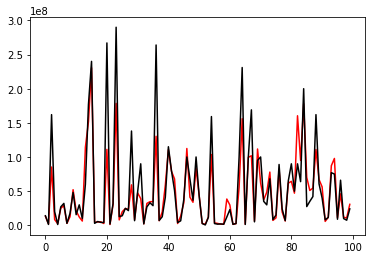

In [106]:
plt.plot(np.exp(preds[:100]),'r')
plt.plot(np.exp(y_lin_validation.values[:100]),'k')

In [107]:
def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [108]:
y_true = np.exp(y_lin_validation)
y_pred = np.exp(model.predict(X_lin_validation))

In [109]:

print(mean_absolute_percentage_error(y_true,y_pred))

36.81867639291055


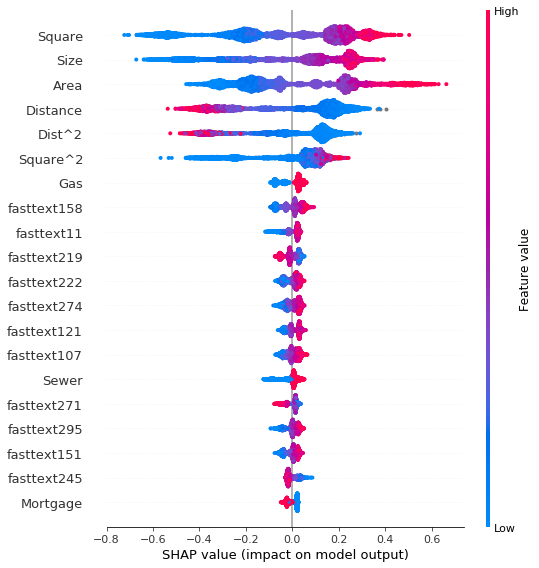

In [110]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_0)
shap.summary_plot(shap_values, X_lin_train)